In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import random
import math as ma
import time
from statistics import mean 
from itertools import combinations
import csv
import codecs
import zipfile as zipfile
from sklearn.decomposition import PCA

In [2]:
# Generate data

paraN=64
agentN=10
dataN=200
sampleN=agentN*dataN
mu=np.zeros((1, sampleN))
Sigma=np.eye(sampleN)
np.random.seed(0)
M=np.random.multivariate_normal(mu[0],Sigma,paraN).T
e=np.random.normal(0, 1, sampleN)

# Normalize data
M =[ma.sqrt(int(paraN))* (np.sqrt(np.abs(LA.eig(np.outer(M[i], M[i]))[0]/ max(LA.eig(np.outer(M[i], M[i]))[0])))).dot(LA.eig(np.outer(M[i], M[i]))[1].T) for i in range(sampleN)]
M=np.real(M)
M=np.array(M)
#e=(2/(np.abs(e)).max(axis=0))*e
#e=np.zeros((sampleN, 1))
e=0.1*e/LA.norm(e)
x_star_nonnorm=np.random.random(size=paraN)-0.5
x_star_norm=300*x_star_nonnorm/LA.norm(x_star_nonnorm)
x_star=np.array(x_star_norm)
y=[M.dot(x_star.T)[i]+e[i] for i in range(sampleN)]
y=np.array(y)
y=y.reshape((sampleN, 1))
y_local=[y[i*dataN:(i+1)*dataN, :] for i in range(agentN)]
y_local=np.array(y_local)
M_local=[M[i*dataN:(i+1)*dataN, :] for i in range(agentN)] # generate groups of local data
M_local=np.array(M_local)
x_star=np.array([x_star for j in range(agentN)])

# Construct the graph
def generate_w(Idx, agentN):
    G=np.zeros([agentN,agentN])
    for i in Idx:
        G[i[0],i[1]] = 1 
    G=G+G.T
    d=G.sum(axis=1)
    # Construct the mixing matrix
    W=np.zeros([agentN,agentN])
    for i in Idx:
        W[i[0], i[1]] = 0.5/max(d[i[0]], d[i[1]])
    W=W+W.T
    diag=np.eye(agentN,agentN)
    for i in range(agentN):
        diag[i,i] = 1 - np.sum(W[i])
    W=W+diag
    return W


epsilon=0.45
p=(1+epsilon)*ma.log(agentN)/agentN
C=0

def erdos(N, p):
    A=np.random.rand(N,N)<p
    A=np.triu(A, 1)
    A=A+A.T
    Lap=np.diag(A*np.ones((N, 1)))-A
    V_L, Lambda_L=np.linalg.eig(Lap)
    if Lambda_L[2,2]<=1e-8:
        C=0
    else:
        C=1
    return A, C

def generate_conn_w(agentN, N, p):
    C=0
    while C==0:
        A1,C=erdos(N, p)
    d=A1.sum(axis=1)
    # Construct the mixing matrix
    W=np.zeros([agentN,agentN])
    A2=A1-np.diag(A1*np.ones((N,1)))
    Idx_n=np.argwhere(A1)
    for i in Idx_n:
        W[i[0], i[1]] = 0.5/max(d[i[0]], d[i[1]])
    diag=np.eye(agentN)
    for i in range(agentN):
        diag[i,i] = 1 - np.sum(W[i])
    W=W+diag
    return W

Idx=[]
for i in range(agentN):
    for j in range(i+1, agentN):
        elem=np.array([[i, j]])
        Idx=Idx+elem.tolist()

print(Idx)
l = [1, 2, 3, 4, 5]
fracx=4


def compute_gamma_e(w, i, frac):
    if frac==0:
        return 1/w[i]
    else:
        w_list=list(w)
        w_list.pop(i)
        w_inverse=np.asarray(list(combinations(w_list, frac)))
        w_inverse=[w_inverse[k]+w[i]/len(w_list) for k in range(w_inverse.shape[0])]
    #    print(w_inverse)
    #    w_inverse2=np.concatenate((w_inverse,w[i]*np.ones(w_inverse.shape[0]).T))
        w_inverse_sum=1/((np.sum(w_inverse, axis=1)))
        return np.sum(w_inverse_sum)

gamma=[(fracx/paraN)**k*(1-fracx/paraN)**(agentN-1-k)*compute_gamma_e(np.asarray(l), 1, k) for k in range(len(l))]
print(compute_gamma_e(np.asarray(l), 0, 3))
print(np.sum(gamma))
print(np.multiply(np.asarray(l), np.asarray(l)))

[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [5, 6], [5, 7], [5, 8], [5, 9], [6, 7], [6, 8], [6, 9], [7, 8], [7, 9], [8, 9]]
0.35912511390579904
0.33246313422797297
[ 1  4  9 16 25]


In [3]:
# Huber loss function and its gradient
def Hloss(Mi, yi, x):
    a=Mi.dot(x)-yi
    if abs(a)<=2:
        return 0.5*a**2
    else:
        return 2*abs(a)-2

def Hloss_grad(Mi, yi, xi):
#    a=Mi.dot(xi.T)-yi
    a=np.dot(Mi, xi.T)-yi
    value=a*Mi
    return value/agentN
#    if abs(a)<=2:
#        value=a*Mi
#        return value/agentN
#    else:
#        return (2*ma.copysign(1,a))*Mi/agentN

def Logistic_grad(Mi, yi, xi, mu, c):
#    c=10
#    gradient_lr(beta,X,y,t,mu):
#    idx_y=[]
#    for iy in range(c):
#        idx=np.where(y==iy)
#        idx_y.append(idx[1])
    cons_1=np.zeros(shape=(c,Mi.shape[1]))
    cons_2=np.zeros(shape=(c,Mi.shape[1]))
    
    for i in range(Mi.shape[1]):
        cons_1[int(yi[i]),:]=cons_1[int(yi[i]),:]+Mi[i,:]

    exp_t=np.exp(-np.dot(xi,Mi.T))
    exp_t_sum=np.sum(exp_t,axis=0)
    exp_t=exp_t/exp_t_sum[None,:]
    cons_2=np.dot(-exp_t,Mi)
    cons_3=2*mu*xi
    grad=(cons_1+cons_2)/Mi.shape[0]+cons_3
    return grad    

def Logistic_sgd(Mi, yi, xi, mu, c, batch_size):
    cons_1=np.zeros(shape=(c,Mi.shape[1]))
    cons_2=np.zeros(shape=(c,Mi.shape[1]))
    
    batch_size=1
    i=random.sample(range(int(dataN_lr)),batch_size)

    cons_1[int(yi[i]), :]=Mi[i, :]
    Mi_new=np.zeros(Mi.shape)
    Mi_new[i, :]=Mi[i, :]
    exp_t=np.exp(-np.dot(xi,Mi_new.T))
    exp_t_sum=np.sum(exp_t,axis=0)
    exp_t=exp_t/exp_t_sum[None,:]
    
    cons_2=np.dot(-exp_t,Mi_new)
    cons_3=2*mu*xi
    grad=cons_1+cons_2+cons_3
    return grad   

def Logistic_sag(old_gradi, Mi, yi, xi, mu, c, batch_size):
    cons_1=np.zeros(shape=(c,Mi.shape[1]))
    cons_2=np.zeros(shape=(c,Mi.shape[1]))
    
    batch_size=1
    i=random.sample(range(int(dataN_lr)),batch_size)

    cons_1[int(yi[i]), :]=Mi[i, :]
    Mi_new=np.zeros(Mi.shape)
    Mi_new[i, :]=Mi[i, :]
    exp_t=np.exp(-np.dot(xi,Mi_new.T))
    exp_t_sum=np.sum(exp_t,axis=0)
    exp_t=exp_t/exp_t_sum[None,:]
    
    cons_2=np.dot(-exp_t,Mi_new)
    cons_3=2*mu*xi
    grad=cons_1+cons_2+cons_3
    return grad   
    

# Compute the gradient at a local agent    
def grad(M_locali, y_locali, x):
    gradi=[Hloss_grad(M_locali[i], y_locali[i], x) for i in range(M_locali.shape[0])]
    gradi=np.array(gradi)
    return gradi

def full_grad(M_local, y_local, x):
    new_grad=np.array([np.sum(grad(M_local[i], y_local[i], x[i]), axis=0) for i in range(agentN)])
    return new_grad

def sag_grad(old_gradi, M_locali, y_locali, x, d):
    id=random.randint(0, dataN-1)
    new_grad=Hloss_grad(M_locali[id], y_locali[id], x)
    d=d-old_gradi[id]+new_grad
    old_gradi[id]=new_grad
#    x=x-alpha1*d/agentN
    return d

def sgd_grad(M_locali, y_locali, x, batch_size):
#    id=random.randint(0, dataN-1)
    id=random.sample(range(dataN),batch_size)
#    new_grad=Hloss_grad(M_locali[id], y_locali[id], x)
    new_grad=np.array(np.mean([Hloss_grad(M_locali[i], y_locali[i], x) for i in id ], axis=0))
    return dataN*new_grad

def full_grad_lr(M_local, y_local, x, mu, c):
    new_grad=np.array([np.sum(Logistic_grad(M_local[i], y_local[i], x[i], mu, c), axis=0) for i in range(agentN)])
    return new_grad

# Generate doubly stochastic matrices
def generate_bisto(agentN):
    M1=np.random.random((agentN,agentN))
    row_diff=max(np.sum(M1, axis=0))-min(np.sum(M1, axis=0))
    col_diff=max(np.sum(M1, axis=1))-min(np.sum(M1, axis=1))
    #while max(np.sum(M1, axis=0))!=1 or min(np.sum(M1, axis=0))!=1:
    for i in range(100):
        M1=np.array([M1[k]/sum(M1[k]) for k in range(agentN)])
        M1=np.array([M1.T[k]/sum(M1.T[k]) for k in range(agentN)])
        M1=M1.T
#        print(max(np.sum(M1, axis=0)), min(np.sum(M1, axis=0)), max(np.sum(M1, axis=1)), min(np.sum(M1, axis=1)))
    return M1

In [6]:
# Consensus - Directed DGD

agentN=10
x_star_init=np.array([10*np.random.random(size=paraN)-5 for j in range(agentN)])
x_star_init=np.array([[x_star_init[i][j] if abs(x_star_init[i][j])<5 else 5 for j in range(paraN)] for i in range(agentN)])
x_star_consensus_ave=np.sum(x_star_init, axis=0)/agentN
x_star_consensus=np.array([x_star_consensus_ave for j in range(agentN)])
p=0.75

z_init=np.vstack((x_star_init, np.zeros((agentN, paraN))))
z_star_consensus_ave=np.sum(x_star_init, axis=0)/(agentN)
z_star_consensus=[z_star_consensus_ave if k< agentN else np.zeros((1, paraN))[0] for k in range(2*agentN)]
#print(z_star_consensus)


N=5000
epsilon=0.01

x_a1_cons=x_star_init
y_a1_cons=np.ones((agentN, 1))
x_a1_hat=np.zeros((agentN, paraN))
x_a2_cons=x_star_init
#mu, sigma = 0, 0.0001


def directed_dp_con(N, sel_num, agentN, paraN, epsilon, sigma, mode):
    z_a1_cons=z_init
    loss_z_cons=[]
    for i in range(int(N)):
        z_a1_cons_col=np.zeros((agentN*2, paraN))
        for j in range(paraN):
            # Construct Matrix M
            # Mechanism 1
            A=np.random.random((agentN,agentN))
            B=np.random.random((agentN, agentN))
            A_new=np.array([A[k] for k in range(agentN)])
            B_new=np.array([B[k] for k in range(agentN)])
            # Mechanism 2
#            p=0.95
#            Wk=generate_conn_w(agentN, agentN, p)
#            A_new=np.array([Wk[k] for k in range(agentN)])
#            B_new=np.array([Wk[k] for k in range(agentN)])
            
            for m in range(agentN):
                w_list=list(range(agentN))
                w_list.pop(m)
                if sel_num=='full':
                    w_num=0
                elif sel_num=='none':
                    w_num=agentN-1
                else:
                    w_num=sel_num
                w_id=random.sample(w_list,w_num)

                A_new[m][w_id]=0
                B_new[m][w_id]=0

            A=np.array([A_new[k]/sum(A_new[k]) for k in range(agentN)]) # Make it row-stochastic            
            B=np.array([B_new.T[k]/sum(B_new.T[k]) for k in range(agentN)]) #Make it column-stochastic
            B=B.T
            s_idx=np.random.binomial(1, 0.9)
            if s_idx==1:
                A=np.eye(agentN)
                B=np.eye(agentN)
            M_up=np.hstack((A, epsilon*np.eye(agentN)))
            M_down=np.hstack((np.eye(agentN)-A, B-epsilon*np.eye(agentN)))
            M_new=np.vstack((M_up, M_down))
        #    M_1=np.array([M_new[k] for k in range(2*agentN)])
            s = np.random.normal(0, sigma, (agentN, 1))
#            z_a1_cons_col_new=np.array([z_a1_cons[k, j]+s[k, 0] if k<agentN else z_a1_cons[k, j]-s[k-agentN, 0] for k in range(agentN*2)])
#            z_a1_cons_col[:, j]=M_new.dot(z_a1_cons_col_new.T)
            z_a1_cons_col[:, j]=M_new.dot(z_a1_cons[:, j])
            if i==0 and mode=='dp':
                z_a1_cons_col_noise=np.array([s[k, 0] if k<agentN else -s[k-agentN, 0] for k in range(agentN*2) ])
                z_a1_cons_col[:, j] += z_a1_cons_col_noise
            

        #    z_a1_cons=M_new.dot(z_a1_cons)
        z_a1_cons=np.array([z_a1_cons_col[k] for k in range(2*agentN)])
        z_a1_ave=np.sum(z_a1_cons, axis=0)/(agentN)
        z_a1_consensus=np.array([z_a1_ave for j in range(agentN)])
        z_a1_consensus_xy=np.vstack((z_a1_consensus, np.zeros((agentN, paraN))))
        #    print(z_a1_cons.shape, z_a1_consensus.shape)
#        loss_z_cons.append(LA.norm(z_a1_cons-z_a1_consensus_xy))
        loss_z_cons.append(LA.norm(z_a1_cons-z_star_consensus))
        print(i)
    return loss_z_cons
    



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


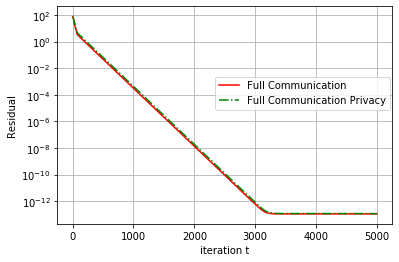

In [33]:

N=5000
#loss_z_cons_f=directed_dp_con(N, "full", agentN, paraN, 0.01, 0.01, 'f')
#loss_z_cons_r=directed_dp_con(N, "full", agentN, paraN, 0.01, 1, 'dp')
#loss_z_cons_r1=directed_dp_con(N, agentN-5, agentN, paraN, 0.01, 0.01, 'f')
#loss_z_cons_r2=directed_dp_con(N, agentN-5, agentN, paraN, 0.01, 1, 'dp')
#loss_z_cons_r3=directed_rew(N, "full", agentN, paraN, 0.01, 0)
#loss_z_cons_r4=directed_rew(N, agentN-5, agentN, paraN, 0.01, 0)

start=1
y_axis = np.random.normal(loc=0.5, scale=0.4, size=1000)
y_axis = y_axis[(y_axis > 0) & (y_axis < 1)]
#plt.ylim((1e-10, 1))
y_axis.sort()    
plt.clf
#plt.ylim((1e-12, 100))
#plt.xlim((1, 2600))
#plt.xscale('log')
plt.yscale('log')
plt.grid()

#plt.plot(loss_z_cons_r3, color='pink', linestyle="--", label ="Full Communication sigma 0")
plt.plot(loss_z_cons_f, color='r', linestyle="-", label ="Full Communication")
plt.plot(loss_z_cons_r, color='g', linestyle="-.", label ="Full Communication Privacy")
#plt.plot(loss_z_cons_r4, color='aqua', linestyle="--", label ="0.5 Communication sigma 0")
#plt.plot(loss_z_cons_r1, color='g', linestyle="-.", label ="0.5 Communication sigma 0.1")
#plt.plot(loss_z_cons_r2, color='b', linestyle="-", label ="0.5 Communication sigma 0.01")


plt.xlabel('iteration t')
plt.ylabel('Residual')
# plt.legend()
plt.legend(bbox_to_anchor=(1.01, 0.70),loc='upper right')
plt.savefig('dp_consensus.eps',dpi=600,format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


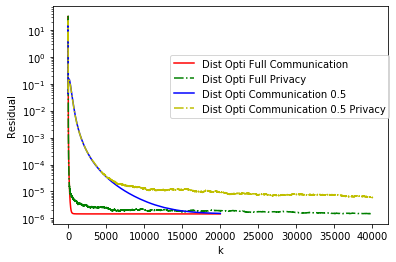

In [31]:
# Linear Regression

def directed_dp_opti(N, sel_num, agentN, paraN, epsilon, sigma, mode):
    z_a1_cons=z_init
#    z_a1_cons=np.zeros((2*agentN, paraN))
    loss_z_cons=[]
    for i in range(int(N)):
#        epsilon=0.001
        # Generate new z
        z_a1_cons_col=np.zeros((agentN*2, paraN))
        for j in range(paraN):
            # Construct Matrix M
            # Mechanism 1
#            A=np.random.random((agentN,agentN))
#            B=np.random.random((agentN, agentN))
#            A_new=np.array([A[k] for k in range(agentN)])
#            B_new=np.array([B[k] for k in range(agentN)])
            # Mechanism 2
            p=0.95
            Wk=generate_conn_w(agentN, agentN, p)
            A_new=np.array([Wk[k] for k in range(agentN)])
            B_new=np.array([Wk[k] for k in range(agentN)])
            for m in range(agentN):
                w_list=list(range(agentN))
                w_list.pop(m)
                if sel_num=='full':
                    w_num=0
                elif sel_num=='none':
                    w_num=agentN-1
                else:
                    w_num=sel_num
                w_id=random.sample(w_list,w_num)
                A_new[m][w_id]=0
                B_new[m][w_id]=0
            A=np.array([A_new[k]/sum(A_new[k]) for k in range(agentN)]) # Make it row-stochastic
            B=np.array([B_new.T[k]/sum(B_new.T[k]) for k in range(agentN)]) #Make it column-stochastic
            B=B.T
            M_up=np.hstack((A, epsilon*np.eye(agentN)))
            M_down=np.hstack((np.eye(agentN)-A, B-epsilon*np.eye(agentN)))
            M_new=np.vstack((M_up, M_down))
        #    M_1=np.array([M_new[k] for k in range(2*agentN)])
            z_a1_cons_col[:, j]=M_new.dot(z_a1_cons[:, j])
        
        # Gradient Computation
        alpha_ddgd=0.2/(i+1)
        x_a1_mid=np.array([z_a1_cons[k] for k in range(agentN)])
        grad_a1_mid=np.array(full_grad(M_local, y_local, x_a1_mid))
        if mode=='dp':
#            s = np.random.normal(0, sigma, (agentN, 1))
            grad_a1_mid_new=np.array([[grad_a1_mid[k, j]+np.random.normal(0, sigma/agentN) for j in range(paraN)] for k in range(agentN)])
            grad_a1_new=np.vstack((grad_a1_mid_new, np.zeros((agentN, paraN))))
            z_a1_cons=z_a1_cons_col-alpha_ddgd*grad_a1_new
        else:    
            grad_a1_new=np.vstack((grad_a1_mid, np.zeros((agentN, paraN))))
            z_a1_cons=z_a1_cons_col-alpha_ddgd*grad_a1_new
        
        # Residual Computation
        x_a1_new=np.array([z_a1_cons[k] for k in range(agentN)])
        loss_z_cons.append(LA.norm(x_a1_new-x_star)/LA.norm(x_star_init-x_star))
        print(i)
    return loss_z_cons

N=20000
#loss_z_cons_fd=directed_dp_opti(N, 'full', agentN, paraN, 0.01, 2, 'f')
#loss_z_cons_rd1=directed_dp_opti(N, 'full', agentN, paraN, 0.01, 2, 'dp')
#loss_z_cons_rd2=directed_dp_opti(N, agentN-5, agentN, paraN, 0.01, 2, 'f')
#loss_z_cons_rd3=directed_dp_opti(N, agentN-5, agentN, paraN, 0.01, 2, 'dp')

    
start=1
y_axis = np.random.normal(loc=0.5, scale=0.4, size=1000)
y_axis = y_axis[(y_axis > 0) & (y_axis < 1)]
y_axis.sort()    
plt.clf()
plt.yscale('log')

plt.plot(loss_z_cons_fd, color='r', linestyle="-", label ="Dist Opti Full Communication")
plt.plot(loss_z_cons_rd1, color='g', linestyle="-.", label ="Dist Opti Full Privacy")
plt.plot(loss_z_cons_rd2, color='b', linestyle="-", label ="Dist Opti Communication 0.5")
plt.plot(loss_z_cons_rd3, color='y', linestyle="-.", label ="Dist Opti Communication 0.5 Privacy")

plt.xlabel('k')
plt.ylabel('Residual')
# plt.legend()
plt.legend(bbox_to_anchor=(1.02,0.8),loc='upper right')

#print(LA.norm(x_star, 'fro'))
plt.savefig('opt_dp.eps',dpi=600,format='eps')